# Exploratory Data Analysis of Epicurious Scrape in a JSON file

This is an idealized workflow for Aaron Chen in looking at data science problems. It likely isn't the best path, nor has he rigidly applied or stuck to this ideal, but he wishes that he worked this way more frequently.

## Purpose: Work through some exploratory data analysis of the Epicurious scrape on stream. Try to write some functions to help process the data.

### Author: Aaron Chen


---

### If needed, run shell commands here

In [ ]:
# !python -m spacy download en_core_web_sm
# !python -c "import tkinter"

---

## External Resources

List out references or documentation that has helped you with this notebook

### Code
Regex Checker: https://regex101.com/

#### Scikit-learn
1. https://scikit-learn.org/stable/modules/decomposition.html#latent-dirichlet-allocation-lda
2. 

### Data

For this notebook, the data is stored in the repo base folder/data/raw

### Process

Are there steps or tutorials you are following? Those are things I try to list in Process

___

## Import necessary libraries

In [1]:
from adjustText import adjust_text
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from datetime import datetime
from joblib import dump, load
import matplotlib.pyplot as plt
import matplotlib.text as mlt
import numpy as np
from openTSNE import TSNE
import pandas as pd
from sklearn import tree
from sklearn.base import TransformerMixin
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
# from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import spacy
from tkinter import N
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
from tqdm import tqdm
from typing import Any
import umap

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


---

## Define helper functions

My workflow is to try things with code cells, then when the code cells get messy and repetitive, to convert into helper functions that can be called.

When the helper functions are getting used a lot, it is usually better to convert them to scripts or classes that can be called/instantiated

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

In [2]:
def concat_matrices_to_df(df, vectorized_ingred_matrix, cv):
    """This function takes in a dataframe and concats the matrix generated by either CountVectorizer or TFIDF-Transformer onto the records so that the recipes can be used for classification purposes.

    Args: 
        df: preprocessed dataframe from preprocess_dataframe
        vectorized_ingred_matrix: sparse csr matrix created from doing fit_transform on the recipe_megalist
     
    Returns:
        A pandas dataframe with the vectorized_ingred_matrix appended as columns to df
    """
    repo_tfidf_df = pd.DataFrame(vectorized_ingred_matrix.toarray(), columns=cv.get_feature_names_out(), index=df.index)
    return pd.concat([df, repo_tfidf_df], axis=1)

In [ ]:
def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()

In [ ]:
def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

In [ ]:
def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()

### Import local script

I started grouping this in with importing libraries, but putting them at the bottom of the list

In [3]:
import project_path

import src.dataframe_preprocessor as dfpp
import src.nlp_processor as nlp_proc

---

## Define global variables 
### Remember to refactor these out, not ideal

In [4]:
data_path = "../../data/recipes-en-201706/epicurious-recipes_m2.json"
food_stopwords_path = "../../food_stopwords.csv"

---

## Running Commentary

1. I used numbered lists to keep track of things I noticed

### To Do

1. Try to determine consistency of nested data structures
   1. Is the photoData or number of things inside photoData the same from record to record
   2. What about for tag?

Data wasn't fully consistent but logic in helper function helped handle nulls

2. How to handle nulls?
   1. Author      Filled in with "Missing Author"
   2. Tag         Filled in with "Missing Cuisine"
3. ~~Convert pubDate to actual timestamp~~  
4. ~~Convert ScrapeDate to actual timestamp~~
   1. This was ignored as the datestamp was not useful (generally within minutes of the origin of UNIX time)
   
**5. Append new columns for relevant nested structures and unfold them**

6. Determine actual types of `ingredients` and `prepSteps`
7. Continue working through test example of single recipe to feed into spaCy and then sklearn.feature_extraction.text stack
8. Will need to remove numbers, punctuation

---

## Importing and viewing the data as a dataframe

In [6]:
sheeeeeesh = pd.read_json(path_or_buf=data_path) # type:ignore
# pd.read_json(data_path, typ='frame') # type:ignore

# sheeeeeesh.set_index('id', inplace=True)

letsgoooo = dfpp.preprocess_dataframe(df=sheeeeeesh) # type:ignore

recipe_megalist = [ingred for recipe in letsgoooo['ingredients'].tolist() for ingred in recipe]

nlp = spacy.load("en_core_web_sm")

# this is a redeem for variable naming mixed with a free pun-ish me daddy, flushtrated will be the list of all stopword to exclude so named because we're throwing these words down the drain

flushtrated = {x for x in pd.read_csv(food_stopwords_path)}
additional_to_exclude = {'red', 'green', 'black', 'yellow', 'white', 'inch', 'mince', 'chop', 'fry', 'trim', 'flat', 'beat', 'brown', 'golden', 'balsamic', 'halve', 'blue', 'divide', 'trim', 'unbleache', 'granulate', 'Frank', 'alternative', 'american', 'annie', 'asian', 'balance', 'band', 'barrel', 'bay', 'bayou', 'beam', 'beard', 'bell', 'betty', 'bird', 'blast', 'bob', 'bone', 'breyers', 'calore', 'carb', 'card', 'chachere', 'change', 'circle', 'coffee', 'coil', 'country', 'cow', 'crack', 'cracker', 'crocker', 'crystal', 'dean', 'degree', 'deluxe', 'direction', 'duncan', 'earth', 'eggland', 'ener', 'envelope', 'eye', 'fantastic', 'far', 'fat', 'feather', 'flake', 'foot', 'fourth', 'frank', 'french', 'fusion', 'genoa', 'genovese', 'germain', 'giada', 'gold', 'granule', 'greek', 'hamburger', 'helper', 'herbe', 'hines', 'hodgson', 'hunt', 'instruction', 'interval', 'italianstyle', 'jim', 'jimmy', 'kellogg', 'lagrille', 'lake', 'land', 'laurentiis', 'lawry', 'lipton', 'litre', 'll', 'maid', 'malt', 'mate', 'mayer', 'meal', 'medal', 'medallion', 'member', 'mexicanstyle', 'monte', 'mori', 'nest', 'nu', 'oounce', 'oscar', 'ox', 'paso', 'pasta', 'patty', 'petal', 'pinche', 'preserve', 'quartere', 'ranch', 'ranchstyle', 'rasher', 'redhot', 'resemble', 'rice', 'ro', 'roni', 'scissor', 'scrap', 'secret', 'semicircle', 'shard', 'shear', 'sixth', 'sliver', 'smucker', 'snicker', 'source', 'spot', 'state', 'strand', 'sun', 'supreme', 'tablepoon', 'tail', 'target', 'tm', 'tong', 'toothpick', 'triangle', 'trimming', 'tweezer', 'valley', 'vay', 'wise', 'wishbone', 'wrapper', 'yoplait', 'ziploc'}

flushtrated = flushtrated.union(STOP_WORDS)
flushtrated = flushtrated.union(additional_to_exclude)
flushtrated_list = list(flushtrated)

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [7]:
custom_nlp_proc = nlp_proc.NLP_Processor("en_core_web_sm")

cv = CountVectorizer(strip_accents='unicode', 
                        lowercase=True, 
                        preprocessor=custom_nlp_proc.custom_preprocessor, 
                        tokenizer=custom_nlp_proc.custom_lemmatizer, 
                        stop_words=flushtrated_list, 
                        token_pattern=r"(?u)\b[a-zA-Z]{2,}\b", 
                        ngram_range=(1,4), 
                        min_df=10
                        )

cv.fit(tqdm(recipe_megalist))

temp = letsgoooo["ingredients"].apply(" ".join).str.lower()

repo_transformed = cv.transform(tqdm(temp))

cv.get_feature_names_out().shape

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
  0%|          | 0/341271 [00:00<?, ?it/s]/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bibb', 'boston', 'breyer', 'chobani', 'hass'

(3351,)

In [8]:
tfidf = TfidfTransformer()

repo_tfidf = tfidf.fit_transform(repo_transformed)

repo_tfidf.shape

(34656, 3351)

In [9]:
recipes_with_cv = concat_matrices_to_df(letsgoooo, repo_tfidf, cv)

We can try to filter out the adjectives in the lemmatization step, because spaCy allows filtering based on Parts of Speech. But this might exclude them from the ngrams. Let's try augmenting stopwords and excluding colors that way.

In [10]:
filtered_df = recipes_with_cv.drop(['dek', 'hed', 'aggregateRating', 'ingredients', 'prepSteps',
       'reviewsCount', 'willMakeAgainPct', 'photo_filename',
       'photo_credit', 'author_name', 'date_published', 'recipe_url'], axis=1)

filtered_df.head()

,cuisine_name,achiote,acid,addition,adobo,adobo adobo,adobo adobo sauce,adobo sauce,adobo sauce chipotle,african,...,zest pith,zest vegetable,zinfandel,ziti,zucchini,zucchini blossom,zucchini crookneck,zucchini squash,árbol,árbol pepper
id,,,,,,,,,,,,,,,,,,,,,
54a2b6b019925f464b373351,Missing Cuisine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a408a019925f464b3733bc,Italian,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a408a26529d92b2c003631,Kosher,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a408a66529d92b2c003638,Kosher,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a408a719925f464b3733cc,Kosher,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
reduced_df = filtered_df[filtered_df['cuisine_name'] != 'Missing Cuisine']
# reduced_df.set_index('id', inplace=True)
y = reduced_df['cuisine_name']
X = reduced_df.drop(['cuisine_name'], axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=240, stratify=y)

In [ ]:
rfc_clf = RandomForestClassifier(max_depth=50, random_state=572, class_weight="balanced", n_jobs=-1)

rfc_clf.fit(X_train, y_train)
print(rfc_clf.score(X_test, y_test))

In [2]:
joblib_basepath = '../../joblib/2022.08.23/'

cv_path = joblib_basepath + 'countvec.joblib'
tfidf_path = joblib_basepath + 'tfidf.joblib'
full_df_path = joblib_basepath + 'recipes_with_cv.joblib'
reduced_df_path = joblib_basepath + 'reduced_df.joblib'
rfc_path = joblib_basepath + 'rfc_clf.joblib'

In [ ]:
dump(cv, cv_path)
dump(tfidf, tfidf_path)
dump(recipes_with_cv, full_df_path)
dump(reduced_df, reduced_df_path)
dump(rfc_clf, rfc_path)

In [5]:
cv = load(cv_path)
tfidf = load(tfidf_path)
recipes_with_cv = load(full_df_path)
reduced_df = load(reduced_df_path)
reduced_df.set_index('id', inplace=True)
rfc_clf = load(rfc_path)

In [ ]:
recipes_with_cv

Sklearn works with DOT formatted trees. ETE does not support this yet. It is a feature being added for ETE milestone 4 but that is as of this stream 50% complete https://github.com/etetoolkit/ete/issues/361

In [6]:
# reduced_df = filtered_df[filtered_df['cuisine_name'] != 'Missing Cuisine']
y = reduced_df['cuisine_name']
X = reduced_df.drop(['cuisine_name'], axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=240, stratify=y)

In [ ]:
X_train.shape

In [ ]:
X_train.head()

In [ ]:
X_train.index

In [ ]:
y_train.index

In [14]:
we_were_talking_about_variable_name = TruncatedSVD(n_components=100, n_iter=15, random_state=268)
we_were_talking_about_variable_name_svd = we_were_talking_about_variable_name.fit_transform(X_train)

Suggestions from hittaus last stream were to take 1000 records, fit tSNE with timing, and then 2000, 3k, etc and look at performance.

In [9]:
we_were_talking_about_variable_name_svd_df = pd.DataFrame(data=we_were_talking_about_variable_name_svd, index=X_train.index)

In [ ]:
we_were_talking_about_variable_name_svd_df_first_samp = we_were_talking_about_variable_name_svd_df.sample(n=1000, replace=False)

In [ ]:
we_were_talking_about_variable_name_svd_df_first_samp.head()

In [ ]:
we_were_talking_about_variable_name_svd_df_first_samp.shape

In [10]:
we_were_talking_about_variable_name_svd_df_nd = we_were_talking_about_variable_name_svd_df.to_numpy()

In [19]:
t_sne = TSNE(n_components=2, learning_rate="auto", perplexity=500, verbose=True, random_state=144, n_jobs=-1)

vis_t_sne = t_sne.fit(we_were_talking_about_variable_name_svd_df_nd)

--------------------------------------------------------------------------------
TSNE(n_jobs=-1, perplexity=500, random_state=144, verbose=True)
--------------------------------------------------------------------------------
===> Finding 1500 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 3.99 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 3.34 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.35 seconds
===> Running optimization with exaggeration=12.00, lr=927.00 for 250 iterations...
Iteration   50, KL divergence 2.7249, 50 iterations in 1.8068 sec
Iteration  100, KL divergence 2.7249, 50 iterations in 1.6660 sec
Iteration  150, KL divergence 2.7249, 50 iterations in 1.6765 sec
Iteration  200, KL divergence 2.7249, 50 iterations in 1.6175 sec
Iteration  250, KL divergence 2.7249, 50 iterations in 1.7293 sec
   --> Time elapsed: 8.50 seconds
===> Running optimization with exaggeration=1.00,

In [ ]:
y_train_samp = y_train.loc[we_were_talking_about_variable_name_svd_df.index]

In [ ]:
y_train_samp.shape

In [12]:
cronozero_rocks = pd.DataFrame(data=y_train, index=y_train.index)

In [ ]:
vis_t_sne[:,0].shape

In [20]:
cronozero_rocks['x'] = vis_t_sne[:,0]

In [21]:
cronozero_rocks['y'] = vis_t_sne[:,1]

In [22]:
cronozero_rocks['cuisine_id_num'] = cronozero_rocks['cuisine_name'].rank(method='min', ascending=False)

In [23]:
cronozero_rocks

,cuisine_name,x,y,cuisine_id_num
id,,,,
54a45bfb6529d92b2c023f25,French,-1.214609,-7.310046,4391.0
54a4638719925f464b395c16,Kosher,0.168884,19.857890,2055.0
54a441126529d92b2c01b5f2,Asian,-11.234784,-4.876577,5991.0
54a409bb19925f464b37380a,American,1.254743,-16.597135,6943.0
54a42e1019925f464b3818d4,Southwestern,-7.332714,1.062514,134.0
...,...,...,...,...
54a436266529d92b2c018767,Italian,1.654323,6.660523,2388.0
54a466e16529d92b2c026f67,French,0.585036,-12.183883,4391.0
54a451cd6529d92b2c01eefd,American,1.435304,-19.972876,6943.0


In [ ]:
plt.style.use('ggplot')
cronozero_rocks.plot.scatter(x='x', y='y', c='cuisine_id_num', colormap='tab20', figsize=(30,20), facecolors="#101010");

In [ ]:
cronozero_rocks['cuisine_name'].value_counts().shape

In [ ]:
random_30 = cronozero_rocks.sample(30, random_state=200)

In [ ]:
reduced_df.loc[random_30.index]

In [ ]:
random_30

In [ ]:
fig, ax = plt.subplots()
plt.plot(random_30['x'], random_30['y'], 'bo')
Texts = [plt.text(  random_30['x'][i], 
                                    random_30['y'][i], 
                                    random_30['cuisine_name'][i], 
                                    ha='center', 
                                    va='center') 
                        for i in range(random_30.shape[0])]
adjust_text(Texts, arrowprops=dict(arrowstyle='->', color='red'))

Let's do some post tSNE Kmeans clustering on our data to see what happens/compare quality

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=30, verbose=50).fit(random_30.drop(['cuisine_name', 'cuisine_id_num'], axis=1))

In [ ]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = random_30['x'].min() - 1, random_30['x'].max() + 1
y_min, y_max = random_30['y'].min() - 1, random_30['y'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(num=1, figsize=(25,15))
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired, 
    aspect="auto",
    origin="lower",
)

plt.plot(random_30['x'], random_30['y'], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)

Texts = [plt.text(  random_30['x'][i], 
                                    random_30['y'][i], 
                                    random_30['cuisine_name'][i], 
                                    ha='center', 
                                    va='center') 
                        for i in range(random_30.shape[0])]
adjust_text(Texts, arrowprops=dict(arrowstyle='->', color='red'))

plt.title(
    "K-means clustering on the 30 random recipes after SVD dimension reduction into tSNE\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

plt.savefig(f"{kmeans.get_params()['n_clusters']}_clusters-{kmeans.get_params()['random_state']}_rand-state.png")
plt.show()

~~Would like to add the text labels for each point as with adjust text, but with the kmeans plot.~~

Next steps
1. More clusters 
2. Then more data
3. pre tSNE stuff

In [ ]:
kmeans.get_params()

Initialization complete
Iteration 0, inertia 2997.913987684178.
Iteration 1, inertia 2384.80883470967.
Iteration 2, inertia 2308.055485476529.
Iteration 3, inertia 2291.9725015512536.
Iteration 4, inertia 2279.38275732028.
Iteration 5, inertia 2269.7988246066293.
Iteration 6, inertia 2248.3499551159503.
Iteration 7, inertia 2242.359537721682.
Iteration 8, inertia 2232.652702482834.
Iteration 9, inertia 2229.8405476718876.
Iteration 10, inertia 2227.201487154289.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 3217.076004855903.
Iteration 1, inertia 2511.379925475382.
Iteration 2, inertia 2280.8888889728482.
Iteration 3, inertia 2237.442363113744.
Iteration 4, inertia 2228.097454703456.
Iteration 5, inertia 2221.185087740029.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 3061.623002459891.
Iteration 1, inertia 2312.8434187451185.
Iteration 2, inertia 2182.067923233072.
Iteration 3, inertia 2087.8723

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


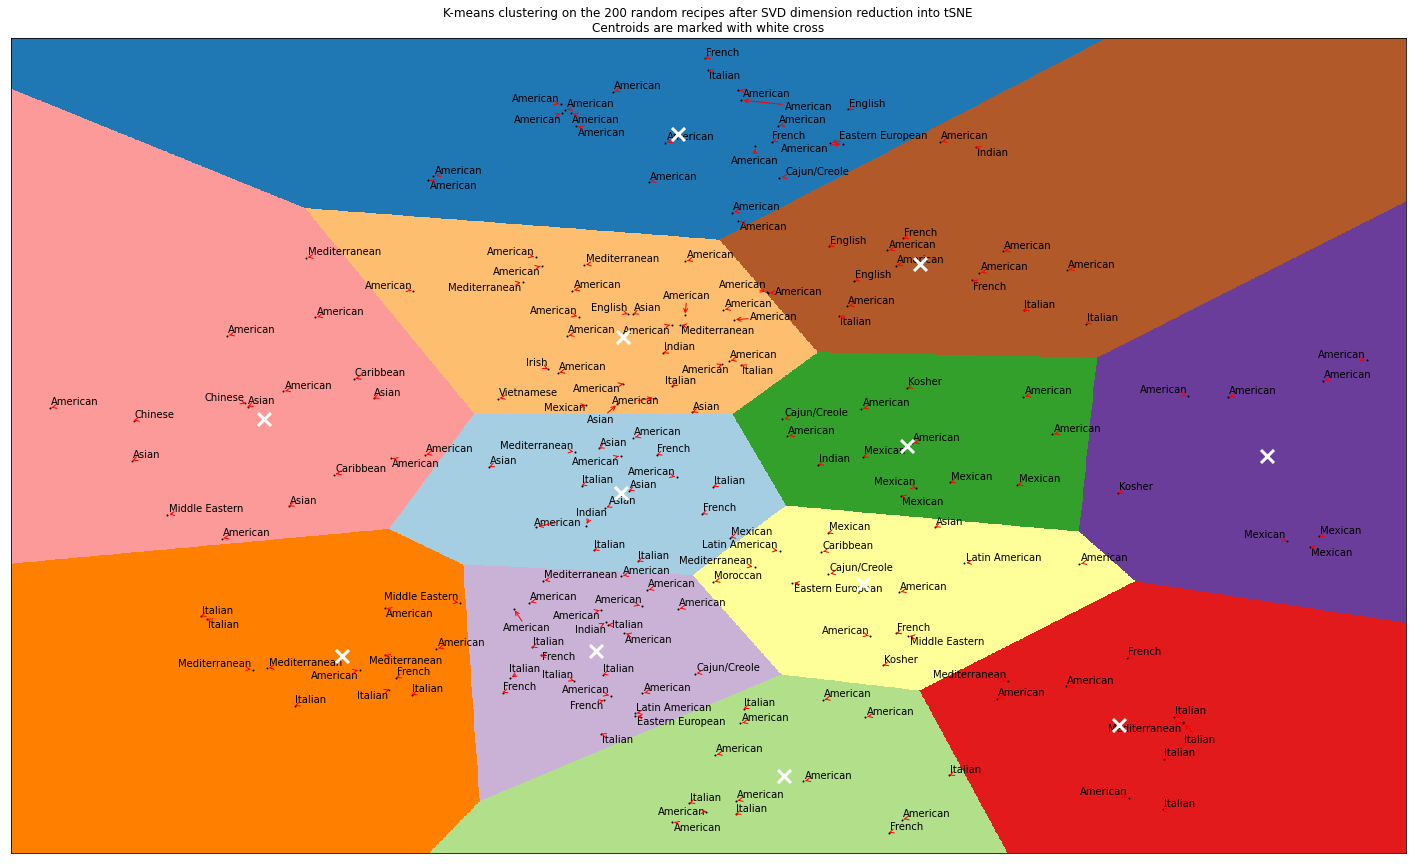

In [24]:
random_200 = cronozero_rocks.sample(200, random_state=313)

kmeans_12 = KMeans(n_clusters=12, random_state=30, verbose=50).fit(random_200.drop(['cuisine_name', 'cuisine_id_num'], axis=1))

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = random_200['x'].min() - 1, random_200['x'].max() + 1
y_min, y_max = random_200['y'].min() - 1, random_200['y'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans_12.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(num=1, figsize=(25,15))
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired, 
    aspect="auto",
    origin="lower",
)

plt.plot(random_200['x'], random_200['y'], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans_12.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)

Texts = [plt.text(  random_200['x'][i], 
                                    random_200['y'][i], 
                                    random_200['cuisine_name'][i], 
                                    ha='center', 
                                    va='center') 
                        for i in range(random_200.shape[0])]
adjust_text(Texts, arrowprops=dict(arrowstyle='->', color='red'))

plt.title(
    "K-means clustering on the 200 random recipes after SVD dimension reduction into tSNE\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

plt.savefig(f"{kmeans_12.get_params()['n_clusters']}_clusters-{kmeans_12.get_params()['random_state']}_rand-state.png")
plt.show()

In [33]:
output_notebook()

Loading BokehJS ...

In [34]:
p = figure(title='KMeans, tSNE, Bokeh')
p.scatter(x=random_200['x'], y=random_200['y'])
show(p)

In [25]:
# Want to joblib X, y, truncatedSVD, we_were_talking_about_variable_name_svd_df_nd, tsne, vis_t_sne, kmeans_12
#joblib_basepath = '../../joblib/2022.08.23/'

X_path = joblib_basepath + 'X.joblib'
y_path = joblib_basepath + 'y.joblib'
truncSVD_path = joblib_basepath + 'truncSVD.joblib'
truncSVD_transformed_path = joblib_basepath + 'truncSVD_transformed.joblib'
svd_numpy_path = joblib_basepath + 'SVD_numpy.joblib'
to_plot_path = joblib_basepath + 'to_plot.joblib'
tsne_path = joblib_basepath + 'tsne.joblib'
tsne_vis_path = joblib_basepath + 'tsne_vis.joblib'
kmeans_path = joblib_basepath + 'kmeans.joblib'

dump(X, X_path)
dump(y, y_path)
dump(we_were_talking_about_variable_name, truncSVD_path)
dump(we_were_talking_about_variable_name_svd, truncSVD_transformed_path)
dump(we_were_talking_about_variable_name_svd_df_nd, svd_numpy_path)
dump(cronozero_rocks, to_plot_path)
dump(t_sne, tsne_path)
dump(vis_t_sne, tsne_vis_path)
dump(kmeans_12, kmeans_path)

['../../joblib/2022.08.23/kmeans.joblib']

In [26]:
test = load(kmeans_path)

In [27]:
test2 = load(to_plot_path)

In [28]:
test2

,cuisine_name,x,y,cuisine_id_num
id,,,,
54a45bfb6529d92b2c023f25,French,-1.214609,-7.310046,4391.0
54a4638719925f464b395c16,Kosher,0.168884,19.857890,2055.0
54a441126529d92b2c01b5f2,Asian,-11.234784,-4.876577,5991.0
54a409bb19925f464b37380a,American,1.254743,-16.597135,6943.0
54a42e1019925f464b3818d4,Southwestern,-7.332714,1.062514,134.0
...,...,...,...,...
54a436266529d92b2c018767,Italian,1.654323,6.660523,2388.0
54a466e16529d92b2c026f67,French,0.585036,-12.183883,4391.0
54a451cd6529d92b2c01eefd,American,1.435304,-19.972876,6943.0
